<a href="https://colab.research.google.com/github/jaswu51/LLM_Finetune/blob/main/3_Finetune_Blip_2_on_memes_datasest_with_Lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.9 MB/s eta 0:00:00


## Load the datasets

In [2]:
from datasets import load_dataset
dataset = load_dataset("marij868/memes_dataset_full",split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/98 [00:00<?, ? examples/s]

In [3]:
dataset.remove_columns("Unnamed: 0")

Dataset({
    features: ['image', 'text'],
    num_rows: 98
})

In [4]:
dataset = dataset.filter(lambda x: x['text'] is not None)


Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

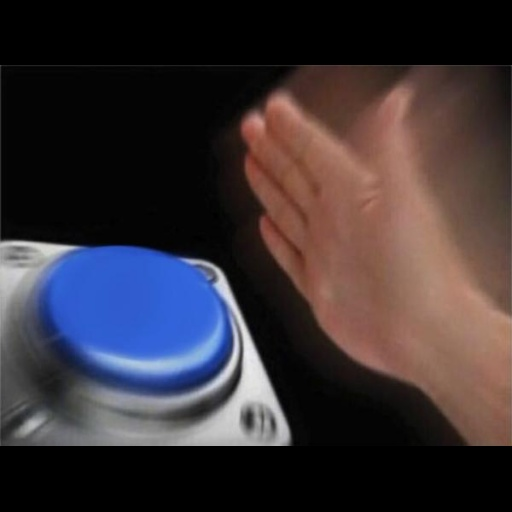

In [5]:
dataset[15]['image']

In [6]:
dataset[15]['text']

'blank blue button, smash button, press button, button slam, button meme, panic button, botton, nut button (crystalbot)'

### Wrap the datasets to Pytorch Dataset after tokenizations

In [7]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [8]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [9]:
train_dataset[16]

{'pixel_values': tensor([[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          ...,
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],
 
         [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          ...,
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],
 
         [[-1.4802, -1.4802, -1.4802,  ..., -1.4802, -1.4802, -1.4802],
          [-

## Load the Blip-2 model

In [10]:
from transformers import Blip2ForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map=device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

### Try the Blip-2 model before finetune

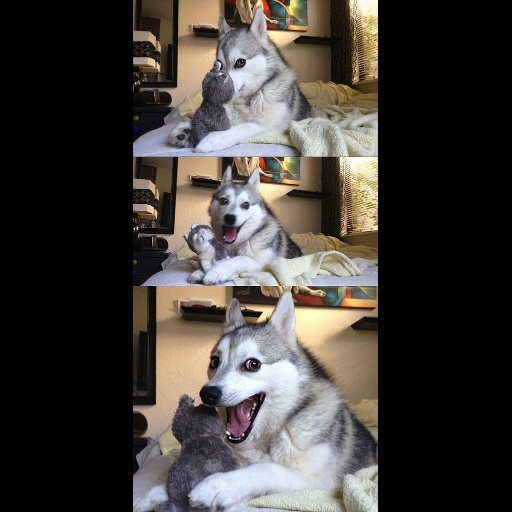

In [11]:
# load image
example = dataset[10]
image = example["image"]
image

In [12]:
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a husky dog is sitting on a bed with a stuffed animal



## Config the model and train

In [13]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [14]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)



model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()


Epoch: 0
Loss: 5.784040451049805
Loss: 6.044337272644043
Loss: 6.050136089324951
Loss: 5.390659809112549
Loss: 5.245024681091309
Loss: 5.341932773590088
Loss: 4.331629276275635
Loss: 4.216542720794678
Loss: 4.670244216918945
Loss: 4.5927324295043945
Loss: 3.683298110961914
Loss: 4.082947731018066
Loss: 3.460578203201294
Loss: 5.475624084472656
Loss: 4.712072372436523
Loss: 4.402054786682129
Loss: 3.539985179901123
Loss: 2.97133207321167
Loss: 3.8173272609710693
Loss: 3.8683881759643555
Loss: 3.765076160430908
Loss: 4.359634876251221
Loss: 3.046483278274536
Loss: 3.373035192489624
Loss: 3.624492883682251
Loss: 3.1379435062408447
Loss: 3.74577260017395
Loss: 3.6473922729492188
Loss: 4.275857448577881
Loss: 3.2088589668273926
Loss: 3.2346646785736084
Loss: 3.320920467376709
Epoch: 1
Loss: 3.1207351684570312
Loss: 3.295968770980835
Loss: 3.1704623699188232
Loss: 3.2067065238952637
Loss: 3.74591064453125
Loss: 2.731294870376587
Loss: 3.2720389366149902
Loss: 2.575521469116211
Loss: 2.876809

## Test the inference

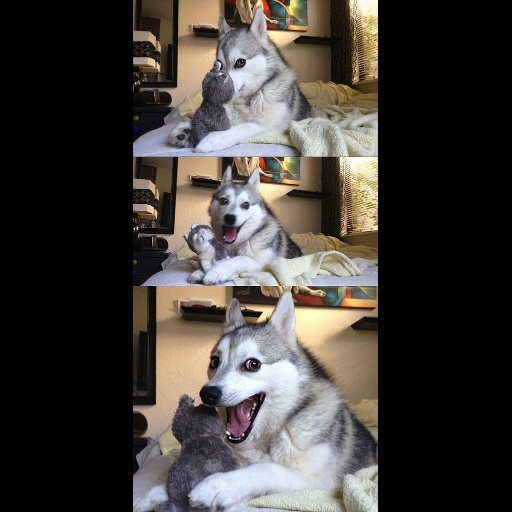

In [15]:
# load image
example = dataset[10]
image = example["image"]
image

In [16]:
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


sad husky, happy husky, angry husky, sad teddy, angry teddy, i will never


## Publish the finetuned model to Huggingface

In [19]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
model.push_to_hub("jaswu/blip2-opt-2.7b-fp16-sharded-memes")

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaswu/blip2-opt-2.7b-fp16-sharded-memes/commit/d646cd23cde10c206a6e8698b387e07ae66e5761', commit_message='Upload model', commit_description='', oid='d646cd23cde10c206a6e8698b387e07ae66e5761', pr_url=None, pr_revision=None, pr_num=None)

## Fetch our model from Huggingface

In [22]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "jaswu/blip2-opt-2.7b-fp16-sharded-memes"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generated caption: blue button, push button, button, button press, button press, button press meme, button meme, button meme meme')

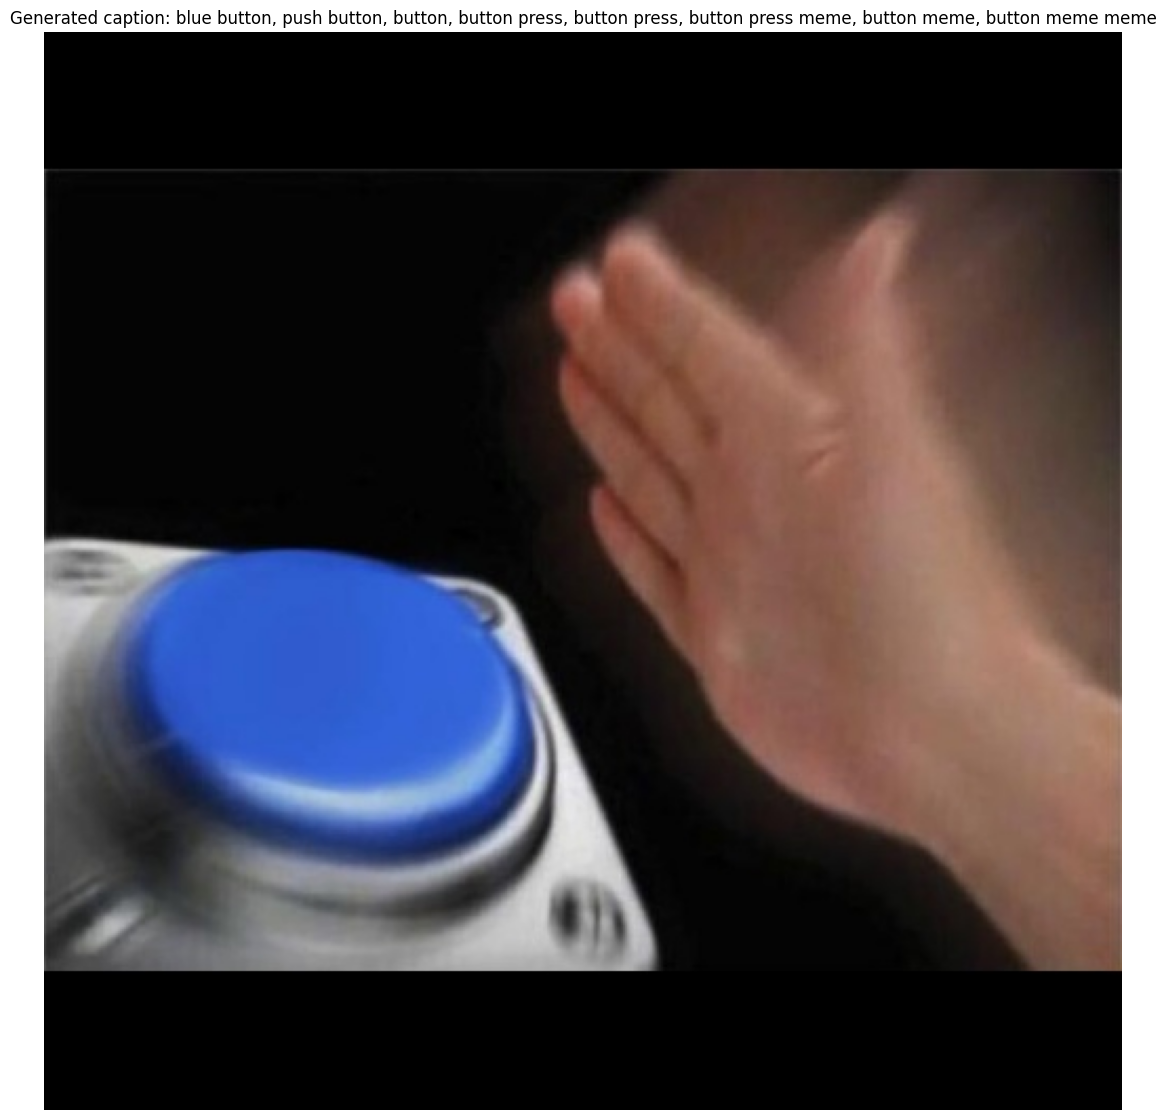

In [23]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

example=dataset[15]
image = example["image"]
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
plt.imshow(image)
plt.axis("off")
plt.title(f"Generated caption: {generated_caption}")